# Regression with Amazon SageMaker XGBoost algorithm
_**Single machine training for regression with Amazon SageMaker XGBoost algorithm**_

---

---
## Contents
1. [Introduction](#Introduction)
2. [Setup](#Setup)
  1. [Fetching the dataset](#Fetching-the-dataset)
  2. [Data Ingestion](#Data-ingestion)
3. [Training the XGBoost model](#Training-the-XGBoost-model)
4. [Set up hosting for the model](#Set-up-hosting-for-the-model)
  1. [Import model into hosting](#Import-model-into-hosting)
  2. [Create endpoint configuration](#Create-endpoint-configuration)
  3. [Create endpoint](#Create-endpoint)
5. [Validate the model for use](#Validate-the-model-for-use)

---
## Introduction

This notebook demonstrates the use of Amazon SageMaker’s implementation of the XGBoost algorithm to train and host a regression model. 

---
## Setup


This notebook was created and tested on an ml.m4.4xlarge notebook instance.

Let's start by specifying:
1. The S3 bucket and prefix that you want to use for training and model data. This should be within the same region as the Notebook Instance, training, and hosting.
1. The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these. Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the boto regexp with a the appropriate full IAM role arn string(s).

### Fetching the dataset

In AWS (training) VM:

Run the following script to create training/validation sets and Sagemaker model that holds index/stats information.

nohup mvn exec:java   -DXms36g -DXmx36g  -Dexec.mainClass=aero.sita.lab.predictive.singleModel.model.Model  -Dexec.args="WSSS 2017-09-01T00:00 2018-09-01T00:00 Asia/Singapore Sagemaker" &


Rename the model with the latest version. (You can see the last version from modelversion table.)

mv Model-TIME_TO_LANDING-WSSS.bin Model-TIME_TO_LANDING-WSSS-6.bin


Upload datasets and model to S3.

aws s3 cp single-WSSS-training.csv s3://sagemaker-models-data/WSSS/TTL/data/

aws s3 cp single-WSSS-validation.csv s3://sagemaker-models-data/WSSS/TTL/data/

aws s3 cp Model-TIME_TO_LANDING-WSSS-6.bin   s3://sita-trained-models/WSSS/

In [2]:
%%time

import os
import boto3
import re
from sagemaker import get_execution_role
import time
from time import gmtime, strftime
from datetime import date, timedelta

import json
import numpy as np

from itertools import islice
import math
import struct

import pandas as pd
from sklearn.datasets import dump_svmlight_file 


role = get_execution_role()
region = boto3.Session().region_name

bucket='sagemaker-models-data' # put your s3 bucket name here, and create s3 bucket
airport = 'WSSS'
model_name = 'TTL'
# customize to your bucket where you have stored the data
bucket_path = 'https://s3-{}.amazonaws.com/{}'.format(region,bucket)
data_path = 's3://' + bucket + "/" + airport + "/"+ model_name + '/data'
TARGET_INDEX = 8

#training_file = 'single-WSSS-training-nowaypoints.csv'
#validation_file = 'single-WSSS-validation-nowaypoints.csv'
#FILE_TRAIN = 'single-WSSS-training-formatted-nowaypoints.csv'

training_file = 'single-WSSS-training-allfeatures-12m.csv'
validation_file = 'single-WSSS-validation-allfeatures-12m.csv'
FILE_TRAIN = 'single-WSSS-train-formatted-allfeatures-12m.csv'
FILE_VALIDATION = 'single-WSSS-validation-formatted-allfeatures-12m.csv'


client = boto3.client('sagemaker')

runtime_client = boto3.client('runtime.sagemaker')
s3 = boto3.resource('s3')

CPU times: user 1.21 s, sys: 173 ms, total: 1.39 s
Wall time: 14.7 s


In [3]:
bucket_path

'https://s3-us-east-1.amazonaws.com/sagemaker-models-data'

In [4]:
def write_to_s3(fobj, bucket, key):
    return boto3.Session().resource('s3').Bucket(bucket).Object(key).upload_fileobj(fobj)

def upload_to_s3(bucket, filename):
    fobj=open(filename, 'rb')
    key = airport + "/"+ model_name + '/data/' + filename
    url = 's3://{}/{}'.format(bucket, key)
    print('Writing to {}'.format(url))
    write_to_s3(fobj, bucket, key)

In [5]:
training_data_set = pd.read_csv(os.path.join(data_path, training_file), header=None)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (2,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,

### INPUT FORMAT

For CSV training, the algorithm assumes that the target variable is in the first column 
and that the CSV does not have a header record. 
For CSV inference, the algorithm assumes that CSV input does not have the label column.

In [49]:
# print(training_data_set.head())
training_data_set.iloc[[0]]

,0,1,2,3,4,5,6,7,8,9,...,1295,1296,1297,1298,1299,1300,1301,1302,1303,1304
0,Airport,Airline,Flightno,Origin,Onapproach,Onground,DayId,Prediction,single,oag_schedule,...,diverted_count_ASUNA,diverted_count_BIKTA,diverted_count_ELALO,diverted_count_MABAL,diverted_count_OBDOS,diverted_count_REPOV,diverted_count_SURGA,diverted_count_TOMAN,diverted_count_VELPI,Departed


In [7]:
validation_data_set = pd.read_csv(os.path.join(data_path, validation_file), header=None)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (2,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,

In [8]:
training_data_set_no_header = training_data_set.iloc[1:,:]
training_data_set_no_header = training_data_set_no_header.reset_index(drop=True)
validation_data_set_no_header = validation_data_set.iloc[1:,:]
validation_data_set_no_header = validation_data_set_no_header.reset_index(drop=True)
frames = [training_data_set_no_header, validation_data_set_no_header]
merged_data_Set = pd.concat(frames, ignore_index=True)

In [24]:
merged_data_Set[6] = pd.to_numeric(merged_data_Set[6])

In [25]:
minDayID = merged_data_Set[6].min()
maxDayID = merged_data_Set[6].max()
midDayID = int((minDayID + maxDayID)/2)
midDayID

1278

In [26]:
new_training_set_ = merged_data_Set[merged_data_Set[6]%4 != 0]
new_training_set_ = new_training_set_.reset_index(drop=True)

new_validation_set_ = merged_data_Set[merged_data_Set[6]%4 == 0]
new_validation_set_ = new_validation_set_.reset_index(drop=True)


In [27]:
new_training_Set = new_training_set_.iloc[:,TARGET_INDEX:]
new_training_Set.to_csv(FILE_TRAIN, header=False, index=False)

In [28]:
print(len(training_data_set))
print(len(validation_data_set))
print(len(new_training_set_))
print(len(new_validation_set_))
print(len(merged_data_Set))

1455161
364606
1357997
461768
1819765


In [39]:
def getIndex(column):
    for i in range (2000):
        if training_data_set.iloc[0,i] == column:
            print(i)
            break
        
getIndex('leadTime')
getIndex('timeLeft')


# Alternate code
# x=training_data_set.iloc[[0]]
# x.columns = x.iloc[0]
# x.columns.get_loc('leadTime')
# x.columns.get_loc('timeLeft')

268
263


test_Set = merged_data_Set[(merged_data_Set[1] == 'BKP')& (merged_data_Set[3] == 'VTSM')& (merged_data_Set[4] == '2018-02-16 07:53:00')]
sorted(pd.to_numeric(test_Set[262]))

test_Set = merged_data_Set[(merged_data_Set[1] == 'JSA')& (merged_data_Set[3] == 'YPPH')& (merged_data_Set[4] == '2018-01-26 20:53:19')]
sorted(pd.to_numeric(test_Set[262]))

training_data_set.iloc[0:1,:]

test_Set = merged_data_Set[(merged_data_Set[1] == 'KAL')& (merged_data_Set[3] == 'RKSI')& (merged_data_Set[4] == '2018-01-27 11:23:13')]
sorted(pd.to_numeric(test_Set[262]))

In [40]:
#upload the files to the S3 bucket
upload_to_s3(bucket, FILE_TRAIN)

Writing to s3://sagemaker-models-data/WSSS/TTL/data/single-WSSS-train-formatted-allfeatures-12m.csv


## Training the XGBoost model

After setting training parameters, we kick off training, and poll for status until training is completed, which in this example, takes between 5 and 6 minutes.

In [41]:
containers = {'us-west-2': '433757028032.dkr.ecr.us-west-2.amazonaws.com/xgboost:latest',
              'us-east-1': '811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest',
              'us-east-2': '825641698319.dkr.ecr.us-east-2.amazonaws.com/xgboost:latest',
              'eu-west-1': '685385470294.dkr.ecr.eu-west-1.amazonaws.com/xgboost:latest'}
container = containers[boto3.Session().region_name]

In [42]:
def trainModel():

    %%time

    job_name = airport + '-' + model_name + '-XGBoost-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
    print("Training job", job_name)

    #Ensure that the training and validation data folders generated above are reflected in the "InputDataConfig" parameter below.

    create_training_params = \
    {
        "AlgorithmSpecification": {
            "TrainingImage": container,
            "TrainingInputMode": "File"
        },
        "RoleArn": role,
        "OutputDataConfig": {
            "S3OutputPath": bucket_path + "/" + airport + "/" + model_name + "/model/xgboost-regression"
        },
        "ResourceConfig": {
            "InstanceCount": 1,
            "InstanceType": "ml.m4.4xlarge",
            "VolumeSizeInGB": 5
        },
        "TrainingJobName": job_name,
        "HyperParameters": {
            "max_depth":"7",
            "eta":"0.2",
            "gamma":"0",
            "min_child_weight":"1",
            "subsample":"0.7",
            "silent":"0",
            "objective":"reg:linear",
            "num_round":"50"
        },
        "StoppingCondition": {
            "MaxRuntimeInSeconds": 3600
        },
        "InputDataConfig": [
            {
                "ChannelName": "train",
                "DataSource": {
                    "S3DataSource": {
                        "S3DataType": "S3Prefix",
                        "S3Uri": bucket_path + "/" + airport + "/" + model_name + '/data/' + FILE_TRAIN,
                        "S3DataDistributionType": "FullyReplicated"
                    }
                },
                "ContentType": "csv",
                "CompressionType": "None"
            }
        ]
    }


    client.create_training_job(**create_training_params)


    status = client.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
    print(status)
    while status !='Completed' and status!='Failed':
        time.sleep(60)
        status = client.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
        print(status)

    if status == 'Failed':
        message = client.describe_training_job(TrainingJobName=job_name)['FailureReason']
        print('Training failed with the following error: {}'.format(message))
        
    return job_name

## Set up hosting for the model
In order to set up hosting, we have to import the model from training to hosting. 

### Import model into hosting

Register the model with hosting. This allows the flexibility of importing models trained elsewhere.

In [43]:
def setupHostingModel(job_name):

    %%time

    model_name=job_name + '-model'
    print(model_name)

    info = client.describe_training_job(TrainingJobName=job_name)
    model_data = info['ModelArtifacts']['S3ModelArtifacts']
    print(model_data)

    primary_container = {
        'Image': container,
        'ModelDataUrl': model_data
    }

    create_model_response = client.create_model(
        ModelName = model_name,
        ExecutionRoleArn = role,
        PrimaryContainer = primary_container)

    print(create_model_response['ModelArn'])
    
    return model_name

### Create endpoint configuration

SageMaker supports configuring REST endpoints in hosting with multiple models, e.g. for A/B testing purposes. In order to support this, customers create an endpoint configuration, that describes the distribution of traffic across the models, whether split, shadowed, or sampled in some way. In addition, the endpoint configuration describes the instance type required for model deployment.

In [48]:
def createEndpointConfiguration(model_name):
    endpoint_config_name = model_name + '-EndpointConfig'  #+ strftime("%Y-%m-%d-%H-%M", gmtime())
    print(endpoint_config_name)
    create_endpoint_config_response = client.create_endpoint_config(
        EndpointConfigName = endpoint_config_name,
        ProductionVariants=[{
            #'InstanceType':'ml.m4.xlarge',
            'InstanceType':'ml.t2.medium',
            'InitialVariantWeight':1,
            'InitialInstanceCount':1,
            'ModelName':model_name,
            'VariantName':'AllTraffic'}])

    print("Endpoint Config Arn: " + create_endpoint_config_response['EndpointConfigArn'])
    
    return endpoint_config_name

### Create endpoint
Lastly, the customer creates the endpoint that serves up the model, through specifying the name and configuration defined above. The end result is an endpoint that can be validated and incorporated into production applications. This takes 9-11 minutes to complete.

In [49]:
def createEndpoint(endpoint_config_name):

    %%time

    endpoint_name = model_name + '-XGBoostEndpoint' # + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
    print(endpoint_name)
    create_endpoint_response = client.create_endpoint(
        EndpointName=endpoint_name,
        EndpointConfigName=endpoint_config_name)
    print(create_endpoint_response['EndpointArn'])

    resp = client.describe_endpoint(EndpointName=endpoint_name)
    status = resp['EndpointStatus']
    print("Status: " + status)

    while status=='Creating':
        time.sleep(60)
        resp = client.describe_endpoint(EndpointName=endpoint_name)
        status = resp['EndpointStatus']
        print("Status: " + status)

    print("Arn: " + resp['EndpointArn'])
    print("Status: " + status)
    
    return endpoint_name

Let's do a whole batch to see how good is the predictions accuracy.

In [44]:
import sys
import math
def do_predict(data, endpoint_name, content_type):
    payload = '\n'.join(data)
    response = runtime_client.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType=content_type, 
                                   Body=payload)
    result = response['Body'].read()
    result = result.decode("utf-8")
    result = result.split(',')
    preds = [float((num)) for num in result]
    #preds = [math.ceil(num) for num in preds]
    return preds

def batch_predict(data, batch_size, endpoint_name, content_type):
    items = len(data)
    arrs = []
    
    for offset in range(0, items, batch_size):
        if offset+batch_size < items:
            results = do_predict(data[offset:(offset+batch_size)], endpoint_name, content_type)
            arrs.extend(results)
        else:
            arrs.extend(do_predict(data[offset:items], endpoint_name, content_type))
        sys.stdout.write('.')
    return(arrs)

In [45]:
starnames = ["STAR ARAMA1A","STAR ARAMA1B","STAR ASUNA1A","STAR ASUNA1B","STAR BIKTA1A","STAR BIKTA1B","STAR ELALO1A","STAR ELALO1B","STAR KARTO1A","STAR KARTO1B","STAR LELIB3B","STAR MABAL1A","STAR MABAL1B","STAR MABAL2A","STAR MABAL2B","STAR OBDOS1A","STAR OBDOS1B","STAR REPOV1A","STAR REPOV1B","STAR SURGA1A","STAR SURGA1B","STAR VELPI1A","STAR VELPI1B"]
starindices = np.zeros(len(starnames))
j=0
for star in starnames:
    for i in range(training_data_set.shape[1]):
        if training_data_set.iloc[0,i] == star:
            starindices[j] = int(i)
    j+=1
            
starBestValues = [18,30,14,26,31,20,44,33,28,27,18,-1000,-1000,40,29,39,39,16,24,42,42,42,32]
#I have set best values for velpi by comparing elalo. need to find out why velpi is detected as star.


def getStarIndex(row):
    j=0
    starIndex = -1
    for i in starindices:
        if row.iloc[int(i)]=="1" :  
            starIndex = j
        j+=1
    #print(starnames[starIndex])
    #print(starBestValues[starIndex])
    return starIndex

def getHoldingSeconds(row):
    starIndex = getStarIndex(row)
    Onapproach = pd.Timestamp(row.iloc[4])
    Onground = pd.Timestamp(row.iloc[5])
    TIS = Onground - Onapproach
    holding = TIS.seconds - starBestValues[starIndex]*60
    #if holding/60>500 :
    #    print("Onappr:" + row.iloc[4] + " Ongrnd:" + row.iloc[5] + " star:" +starnames[starIndex]+ " best:" + str(starBestValues[starIndex]) + " TIS:" + str(TIS) + " hold:" + str(int(holding/60)) )
    return holding

def dailyCongestionScores(data_set):
    dailyHoldings = {}
    for i in range(len(data_set)): #
        holding = getHoldingSeconds(data_set.iloc[i,:])
        dayID = data_set.iloc[i,TARGET_INDEX-2]
        dailyHolding = dailyHoldings.get(dayID, [])
        dailyHolding.append(holding)
        dailyHoldings[dayID] = dailyHolding
    #print(dailyHoldings)
    
    dailyScores = {}
    for dayID in dailyHoldings.keys():
        dailyHolding = dailyHoldings[dayID]
        dailyScore = 0
        for holding in dailyHolding:
            if holding > 0:
                holding = holding/60 # to minute
                dailyScore +=  (holding*holding)
        dailyScore = math.sqrt(dailyScore / len(dailyHolding))         
        dailyScores[dayID] = dailyScore
    return dailyScores

In [46]:
training_data_set.iloc[0:1,:]

,0,1,2,3,4,5,6,7,8,9,...,1295,1296,1297,1298,1299,1300,1301,1302,1303,1304
0,Airport,Airline,Flightno,Origin,Onapproach,Onground,DayId,Prediction,single,oag_schedule,...,diverted_count_ASUNA,diverted_count_BIKTA,diverted_count_ELALO,diverted_count_MABAL,diverted_count_OBDOS,diverted_count_REPOV,diverted_count_SURGA,diverted_count_TOMAN,diverted_count_VELPI,Departed


In [47]:
def unifyMultipleFlightCopies(data_set):
    unified_set = {}
    for i in range(len(data_set)): 
        key = str(data_set.iloc[i,0]) + str(data_set.iloc[i,1]) + str(data_set.iloc[i,2]) + str(data_set.iloc[i,3]) + str(data_set.iloc[i,4])
        unified_set[key] = data_set.iloc[i,:]
    return pd.DataFrame.from_dict(unified_set, orient='index')

In [48]:
unified_set = unifyMultipleFlightCopies(new_validation_set_)
dailyValidationScores = dailyCongestionScores(unified_set)
dailyValidationScores

{1096: 5.136028388549204,
 1100: 5.435828917352332,
 1104: 4.6824287723545455,
 1112: 5.053589508665549,
 1116: 8.11782043600186,
 1120: 10.39490747918373,
 1124: 9.459682489179684,
 1128: 11.523113587301614,
 1132: 16.79449654125047,
 1136: 10.721160688883174,
 1140: 9.248082393846596,
 1144: 5.772280807188804,
 1148: 4.685586173891566,
 1152: 5.102864215860187,
 1156: 6.059625473366011,
 1160: 6.330298458321581,
 1164: 6.311890134556136,
 1168: 4.436357200636601,
 1172: 7.731996610877175,
 1176: 4.413637690409263,
 1180: 5.690662271680488,
 1184: 5.2777830563963715,
 1188: 4.00676951959515,
 1192: 6.509791268000931,
 1196: 5.512149245818376,
 1200: 6.420572608462975,
 1204: 4.7735958484540015,
 1208: 5.703613653527798,
 1212: 10.046675482781636,
 1216: 2.9217747590931373,
 1220: 2.642918101818351,
 1224: 4.196274820096585,
 1228: 2.6178751252015715,
 1244: 3.8043433131117985,
 1260: 4.287834072058301,
 1264: 6.51222992351921,
 1268: 4.387161440892172,
 1272: 3.831634677217253,
 1276:

In [52]:
#dailyValidationScores = dailyCongestionScores(new_validation_set_)
#dailyValidationScores

{1244: 4.203485369302701,
 1308: 7.7073008287611735,
 1300: 3.400363399019427,
 1384: 4.82923233688781,
 1436: 7.843968993816006,
 1280: 6.006948727386795,
 1176: 4.685478182883774,
 1140: 9.757404119604953,
 1404: 9.685296991997216,
 1112: 5.194633648757194,
 1252: 5.925115704485511,
 1188: 4.304964408203699,
 1292: 6.644384460362639,
 1192: 7.010859938565971,
 1428: 7.3079674191458395,
 1224: 4.635438381606416,
 1408: 6.295337871815015,
 1172: 8.355732519933529,
 1160: 6.69661959917541,
 1268: 4.669519427394575,
 1380: 11.442246113517056,
 1156: 6.737627356470265,
 1116: 8.549480054081215,
 1164: 6.655144341262438,
 1448: 6.840629752659661,
 1220: 2.8622261002441918,
 1320: 6.013977059798402,
 1208: 6.251634827874973,
 1444: 6.888003411974368,
 1144: 6.281670269122254,
 1256: 4.895015935861801,
 1272: 3.9748660305871084,
 1180: 6.080803174136497,
 1456: 7.114909612615227,
 1452: 8.196829463029284,
 1100: 5.802928705439857,
 1412: 13.710992908758332,
 1120: 11.557495996695689,
 1336: 

In [59]:
dailyTrainingScores = dailyCongestionScores(new_training_set_)
dailyTrainingScores

{1449: 10.057964723551825,
 1262: 3.6067399918765566,
 1267: 10.536677551202274,
 1306: 4.59059698647517,
 1141: 5.867455107811418,
 1253: 4.241087686996094,
 1393: 6.154801901417247,
 1307: 4.4248402604429975,
 1137: 7.433909732611579,
 1377: 5.724048481426331,
 1210: 4.304247359690595,
 1221: 6.918669404006272,
 1265: 3.018156190098912,
 1347: 6.803344526932069,
 1279: 6.9347149637096255,
 1419: 5.336948826237586,
 1353: 4.777243258828115,
 1314: 4.202706496599602,
 1270: 4.160969147925827,
 1159: 8.110663187342524,
 1294: 3.955784682762851,
 1121: 5.97356755325067,
 1354: 4.253404395181469,
 1097: 4.506464508682607,
 1406: 6.755119816509851,
 1250: 5.119189665909084,
 1385: 8.334500672510298,
 1146: 5.2566746397293995,
 1299: 6.408639818494658,
 1274: 5.734120912343923,
 1198: 5.982859811474484,
 1170: 5.474987750291962,
 1297: 3.4241163858401453,
 1102: 7.083350181944046,
 1117: 5.639876012693112,
 1350: 6.267924233360371,
 1367: 5.336217870950912,
 1167: 7.098012872867356,
 1254: 

In [60]:
sorted(dailyValidationScores)

[1096,
 1100,
 1104,
 1108,
 1112,
 1116,
 1120,
 1124,
 1128,
 1132,
 1136,
 1140,
 1144,
 1148,
 1152,
 1156,
 1160,
 1164,
 1168,
 1172,
 1176,
 1180,
 1184,
 1188,
 1192,
 1196,
 1200,
 1204,
 1208,
 1212,
 1216,
 1220,
 1224,
 1228,
 1232,
 1244,
 1248,
 1252,
 1256,
 1260,
 1264,
 1268,
 1272,
 1276,
 1280,
 1284,
 1288,
 1292,
 1296,
 1300,
 1304,
 1308,
 1312,
 1316,
 1320,
 1324,
 1328,
 1332,
 1336,
 1340,
 1344,
 1348,
 1352,
 1356,
 1360,
 1364,
 1368,
 1372,
 1376,
 1380,
 1384,
 1388,
 1392,
 1396,
 1400,
 1404,
 1408,
 1412,
 1416,
 1420,
 1424,
 1428,
 1432,
 1436,
 1440,
 1444,
 1448,
 1452,
 1456,
 1460]

In [50]:
import matplotlib.pyplot as plt

def plotDailyKPIs(dailyTotal, dailyPct, leadIndex, catIndex, title ): 
    dailyKPIs = np.zeros(len(dailyTotal))
    dd = 0
    for dayID in sorted(dailyTotal):
        dpct = dailyPct[dayID]
        dailyKPIs[dd] = dpct[leadIndex][catIndex]
        dd = dd+1

    # Create plots with pre-defined labels.
    fig, ax = plt.subplots(figsize=(10,10))

    
    sorted_dailyValidationScores = [70+100/dailyValidationScores[i] for i in sorted(dailyValidationScores)]

    ax.plot(sorted(dailyTotal)-minDayID, dailyKPIs, 'C2', label='single_all_features')
    ax.plot(sorted(dailyTotal)-minDayID, sorted_dailyValidationScores, 'C3', label='congestion_scores')
    ax.set_title(title)
    ax.set_xlabel('days')
    ax.set_ylabel('KPI')

    legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large', bbox_to_anchor=(1.3, 1.05))

    # Put a nicer background color on the legend.
    legend.get_frame().set_facecolor('C1')

    plt.show()

In [62]:
import matplotlib.pyplot as plt

def plotDailyKPIsOld(dailyTotal, dailyPct, leadIndex, catIndex, title ): 
    dailyKPIs_2hr_10 = np.zeros(len(dailyTotal))
    dd = 0
    for dayID in dailyTotal.keys():
        dpct = dailyPct[dayID]
        dailyKPIs_2hr_10[dd] = dpct[leadIndex][catIndex]
        dd = dd+1
        
    plt.figure(figsize=(10,10))
    plt.xlabel('day')
    plt.ylabel(title)
    plt.scatter(dailyTotal.keys(), dailyKPIs_2hr_10, s=10)
    plt.show()


In [125]:
import matplotlib.pyplot as plt


#minLead = [ -1,15,30,45,60, 90,120,180,240,360 ] 
#maxLead = [ 15,30,45,60,90,120,180,240,360,100000 ]

#minLead = [ 25,55,85, 60,115,175,120,235,355,715] 
#maxLead = [ 35,65,95,120,125,185,240,245,365,725]
#30 min 1hour 90 min 1-2 hours 2 hours 3 hours 2-4 hours 4hours 6 hours 12 hours

minLead = [25,55,85,115,175,235,295,355,715,1435] 
maxLead = [35,65,95,125,185,245,305,365,725,1445]
categorySize = 10

catSize = 3
leadSize = 10

def computeAccuraciesNew(days, preds, labels, mode): 
    total = np.zeros((leadSize))

    count = np.zeros((leadSize,catSize))
    pct = np.zeros((leadSize,catSize))

    total2 = 0.0
    pct2 = np.zeros((leadSize))


    dailyTotal = {} #    Map<Integer, Double> dailyTotal = new HashMap<>();
    dailyPct = {}   #    Map<Integer, double[]> dailyPct = new HashMap<>();
    pct2avg = np.zeros((leadSize,catSize))
    pct2sdev = np.zeros((leadSize,catSize))
    pct2min = np.zeros((leadSize,catSize))
    pct2max = np.zeros((leadSize,catSize))
    minDay = -1
    maxDay = -1

    for i in range(len(preds)):
        have = preds[i]
        want = labels[i]
        error = np.abs(have-want)
        dayID = days[i]
            
        idx = getLeadIndex(want)
        if idx == -1:
            continue

        total[idx] += 1
        total2 += 1

        limit = 0
        for i in range(catSize):
            limit += 5*60
            if (error <= limit):
                pct[idx][i] += 1
                count[idx][i] += 1
                pct2[idx] += 1
            

        #_____fillStatsDaily___________
        dtotal = dailyTotal.get(dayID, np.zeros((leadSize)))
        dtotal[idx] += 1
        dailyTotal[dayID] = dtotal

        dpct = dailyPct.get(dayID, np.zeros((leadSize,catSize)))
        limit = 0
        for i in range(catSize):
            limit += 5*60
            if (error <= limit):
                dpct[idx][i] += 1
                
        dailyPct[dayID] = dpct
        #____fillStatsDaily  end_____
        
       
    for idx in range(leadSize):
        for i in range(catSize):
            if total[idx] > 0:
                pct[idx][i] = pct[idx][i] * 100 / total[idx]
            else: 
                pct[idx][i] = -100
            
        if total2 > 0:
            pct2[idx] = pct2[idx] * 100 / total2    
        else: 
            pct2[idx] = -100
        
    
    #_____computePercentagesDaily
    for i in range(leadSize):
        for j in range(catSize):
            pct2min[i][j] = float("inf")
            pct2max[i][j] = -float("inf")
            pct2sdev[i][j] = 0
            pct2avg[i][j] = 0


       
    ddtotal = np.zeros(len(dailyTotal))
    dd = 0
    for dayID in dailyTotal.keys():
        ddtotal[dd] = dailyTotal[dayID][1]
        dd = dd+1
        
    plt.figure(figsize=(10,10))
    plt.xlabel('day')
    plt.ylabel('count')
    plt.scatter(dailyTotal.keys(), ddtotal, s=10)
    plt.show()
            
    dayCount = 0
    for dayID in dailyTotal.keys():
        dtotal = dailyTotal[dayID]
        dpct = dailyPct[dayID]

        
        for i in range(leadSize):
            for j in range(catSize):
                if dpct[i][j] == 0 and dtotal[i] > 0 :
                    print("i " + str(i) + " j " + str(j) +" "+ str(getDayFromDayID(dayID)) +" " +  str(dtotal[i]))
                
                
                if (dtotal[i] > 0) :
                    dpct[i][j] = dpct[i][j] * 100. / dtotal[i]
                    pct2avg[i][j] += dpct[i][j]

                    if(pct2min[i][j] > dpct[i][j]):
                        pct2min[i][j] = dpct[i][j]
                        minDay = dayID

                    if(pct2max[i][j] < dpct[i][j]):
                        pct2max[i][j] = dpct[i][j]
                        maxDay = dayID

        dayCount+=1


    for i in range(leadSize):
        for j in range(catSize):
            pct2avg[i][j] = pct2avg[i][j] / dayCount

    
    # Saving the objects:
    with open('dailyPct_allfeatures.pkl', 'wb') as f: 
        pickle.dump(dailyPct, f)
    
    plotDailyKPIs(dailyTotal, dailyPct, 0, 0, 'dailyKPIs_30min_5' )      
    plotDailyKPIs(dailyTotal, dailyPct, 1, 1, 'dailyKPIs_1hr_10' )     
    plotDailyKPIs(dailyTotal, dailyPct, 2, 1, 'dailyKPIs_2hr_10' )
            
    # Calculate the standard deviation
    for dayID in dailyTotal.keys() :
        dtotal = dailyTotal[dayID]
        for i in range(leadSize):
            dpct = dailyPct[dayID]
            if (dtotal[i] > 0) :
                for j in range(catSize):
                    diff = dpct[i][j]-pct2avg[i][j]
                    pct2sdev[i][j] += diff*diff

    for i in range(leadSize):
        for j in range(catSize):
            pct2sdev[i][j] = pct2sdev[i][j] / (dayCount - 1)
            pct2sdev[i][j] = math.sqrt(pct2sdev[i][j])
  
    #_____computePercentagesDaily____end
    leadTimes = ["30m","1hr","90m","2hr","3hr","4hr","5hr","6hr","12h","24h"]
  

    print('\n' + mode + " time-to-landing (vertical) by accuracy (horizontal)")
    print("+----+------+------+-----+------+------+------+------+-----+------+------+------+------+-----+------+------+------+")
    print("|    | <= 5 | AVG  | STD | MIN  | MAX  | <=10 | AVG  | STD | MIN  | MAX  | <=15 | AVG  | STD | MIN  | MAX  | SIZE |")
    print("+----+------+------+-----+------+------+------+------+-----+------+------+------+------+-----+------+------+------+")
    for i in range(leadSize):
        buf = "|"
        buf += leadTimes[i] + " "
        for j in range(catSize):
            if (pct[i][j] < -99):
                buf += "| ---- "
            else:
                buf += "|%5.1f%%" % pct[i][j]
        
            buf += "|%5.1f%%" % pct2avg[i][j]
            buf += "|%4.1f%%" % pct2sdev[i][j]
            buf += "|%5.1f%%" % pct2min[i][j]
            buf += "|%5.1f%%" % pct2max[i][j]
        buf += "|%6d|" % total[i]
        print(buf)
    
    print("+----+------+------+-----+------+------+------+------+-----+------+------+------+------+-----+------+------+------+")
    print(mode+" worstDay: " + str(getDayFromDayID(minDay)) + " bestDay: " + str(getDayFromDayID(maxDay)))
    



def computeAccuracies(days, preds, labels, mode): 
    total = np.zeros((categorySize))

    count = np.zeros((categorySize,10))
    pct = np.zeros((categorySize,10))

    total2 = 0.0
    pct2 = np.zeros((10))


    dailyTotal = {} #    Map<Integer, Double> dailyTotal = new HashMap<>();
    dailyPct = {}   #    Map<Integer, double[]> dailyPct = new HashMap<>();
    pct2avg = np.zeros((10))
    pct2sdev = np.zeros((10))
    pct2min = np.zeros((10))
    pct2max = np.zeros((10))
    minDay = -1
    maxDay = -1

    for i in range(len(preds)):
        have = preds[i]
        want = labels[i]
        error = np.abs(have-want)
        dayID = days[i]
            
        idx = getLeadIndex(want)
        if idx == -1:
            continue

        total[idx] += 1
        total2 += 1

        limit = 0
        for i in range(len(pct)):
            limit += 5*60
            if (error <= limit):
                pct[idx][i] += 1
                count[idx][i] += 1
                pct2[i] += 1
            

        #_____fillStatsDaily___________
        dtotal = dailyTotal.get(dayID, 0)
        dtotal += 1
        dailyTotal[dayID] = dtotal

        dpct2 = dailyPct.get(dayID, np.zeros((10)))
        limit = 0
        for i in range(len(pct)):
            limit += 5*60
            if (error <= limit):
                dpct2[i] += 1
                
        dailyPct[dayID] = dpct2
        #____fillStatsDaily  end_____
        
       
    for i in range(10):
        for idx in range(10):
            if total[idx] > 0:
                pct[idx][i] = pct[idx][i] * 100 / total[idx]
            else: 
                pct[idx][i] = -100
            
        if total2 > 0:
            pct2[i] = pct2[i] * 100 / total2    
        else: 
            pct2[i] = -100
        
    
    #_____computePercentagesDaily
    for i in range(10):
        pct2min[i] = float("inf")
        pct2max[i] = -float("inf")
        pct2sdev[i] = 0
        pct2avg[i] = 0


    dayCount = 0
    for dayID in dailyTotal.keys():
        dtotal = dailyTotal[dayID]
        dpct2 = dailyPct[dayID]

        if (dtotal > 0) :
            for i in range(10):
                dpct2[i] = dpct2[i] * 100 / dtotal
                pct2avg[i] += dpct2[i]

                if(pct2min[i] > dpct2[i]):
                    pct2min[i] = dpct2[i]
                    minDay = dayID

                if(pct2max[i] < dpct2[i]):
                    pct2max[i] = dpct2[i]
                    maxDay = dayID

            dayCount+=1


    for i in range(10):
        pct2avg[i] = pct2avg[i] / dayCount


    # Calculate the standard deviation
    for dayID in dailyTotal.keys() :
        dtotal = dailyTotal[dayID]
        dpct2 = dailyPct[dayID]
        if (dtotal > 0) :
            for i in range(10):
                diff = dpct2[i]-pct2avg[i]
                pct2sdev[i] += diff*diff

    for i in range(10):
        pct2sdev[i] = pct2sdev[i] / (dayCount - 1)
        pct2sdev[i] = math.sqrt(pct2sdev[i])
  
    #_____computePercentagesDaily____end

    print('\n' + mode + " accuracy (vertical) by time-to-landing (horizontal)")
    print(mode + " +----+------+------+------+------+------+------+------+------+------+------+------+------+----+------+------+")
    print(mode + " |    |  30m |  1hr |  90m |  2hr |  3hr |  4hr |  5hr |  6hr | 12hr | 24hr | ALL  | AVG  |STD | MIN  | MAX  |")
    print(mode + " +----+------+------+------+------+------+------+------+------+------+------+------+------+----+------+------+")
       
   # print(mode + " +-----+------+------+------+------+------+------+------+------+------+------+------+------+----+------+------+")
   # print(mode + " |     | <15m | <30m | <45m | <60m | <90m | <2hr | <3hr | <4hr | <6hr | 6hr+ | ALL  | AVG  |STD | MIN  | MAX  |")
   # print(mode + " +-----+------+------+------+------+------+------+------+------+------+------+------+------+----+------+------+")
    for i in range(len(pct)):
        buf = mode
        buf += " |<=%2d" % ((i+1)*5)
        for idx in range(10):
            if (pct[idx][i] < -99):
                buf += "| ---- "
            else:
                buf += "|%5.1f%%" % pct[idx][i]
            
        
        if pct2[i] < -99:
            buf += "| ---- "
        
        else:
            buf += "|%5.1f%%" % pct2[i]
        
        buf += "|%5.1f%%" % pct2avg[i]
        buf += "|%3.1f%%" % pct2sdev[i]
        buf += "|%5.1f%%" % pct2min[i]
        buf += "|%5.1f%%" % pct2max[i]
        buf += "|"
        print(buf)
    
    print(mode+" +----+------+------+------+------+------+------+------+------+------+------+------+");
    buf = mode
    buf += " |SIZE"
    for idx in range(10):
        buf += "|%5d " % total[idx]
    
    buf += "|%5d" % total2
    buf += " |"
    print(buf)

    print(mode+" +----+------+------+------+------+------+------+------+------+------+------+------+");
    print(mode+" worstDay: " + str(getDayFromDayID(minDay)) + " bestDay: " + str(getDayFromDayID(maxDay)))
    

    
def getLeadIndex(want):
    leadTime = want / 60 # convert to minutes 
    for i in range(len(maxLead)):
        if leadTime > minLead[i] and leadTime < maxLead[i]: 
            return i  
    return -1 

    
def getDayFromDayID(dayID):
    initialDay = date(2015, 1, 1)
    return initialDay + timedelta(days=int(dayID))


def computeRSquare(y, y_fit):
    #y = [float(i) for i in y]
    #y_fit = [float(i) for i in y_fit]
    #y = np.array(y)
    #y_fit = np.array(y_fit)

    # residual sum of squares
    ss_res = np.sum((y - y_fit) ** 2)
    # total sum of squares
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    # r-squared
    r2 = 1 - (ss_res / ss_tot)
    return r2


def computeRSquareAdjusted(R2, k, n):
    # k – number of parameters
    # n – number of observations 
    R2adjusted = R2 - (1-R2)*(k-1)/(n-k)
    print('\nr-squared-adjusted = ' + str(R2adjusted) + " where number of parameters:" + str(k) + " and number of observations:" + str(n))


def getPredictions(dataset, mode):
    featureSet = dataset.iloc[:,(TARGET_INDEX+1):] # skip upto target column(included)
    labels = dataset.iloc[:,TARGET_INDEX] #target column
    
    filename = job_name + '_' + mode +'.libsvm'
    dump_svmlight_file(X=featureSet, y=labels, f=filename)

    %%time
    with open(filename, 'r') as f:
        payload = f.read().strip()

    test_data = [line for line in payload.split('\n')]
    preds = batch_predict(test_data, 100, endpoint_name, 'text/x-libsvm')
    return preds


def test(dataset, preds, mode):    
    preds = preds.iloc[:,0]
    
    labels_ = dataset.iloc[:,TARGET_INDEX]
    labels = [float(i) for i in labels_]
    days_ = dataset.iloc[:,TARGET_INDEX-2]
    days = [float(i) for i in days_]
    
    print('\nMedian Absolute Percent Error (MdAPE) = ', np.median(np.abs(np.array(labels) - np.array(preds)) / np.array(labels)))

    R2 = computeRSquare(np.array(labels), np.array(preds))
    print('\nr-squared = ', R2)
    R2adjusted = computeRSquareAdjusted(R2, dataset.shape[1]-TARGET_INDEX-1, dataset.shape[0] )

    #computeAccuracies(days, preds, labels, mode)
    computeAccuraciesNew(days, preds, labels, mode)
    
   

The following helps us calculate the Median Absolute Percent Error (MdAPE) on the batch dataset. 

In [65]:
model_name = 'TTL'


## MAIN METHOD

In [66]:
job_name = trainModel()
model_name = setupHostingModel(job_name)
endpoint_config_name = createEndpointConfiguration(model_name)
endpoint_name = createEndpoint(endpoint_config_name)

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 15.3 µs
Training job WSSS-TTL-XGBoost-2019-11-13-11-06-56
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
Completed
CPU times: user 8 µs, sys: 1 µs, total: 9 µs
Wall time: 32.2 µs
WSSS-TTL-XGBoost-2019-11-13-11-06-56-model
https://s3-us-east-1.amazonaws.com/sagemaker-models-data/WSSS/TTL/model/xgboost-regression/WSSS-TTL-XGBoost-2019-11-13-11-06-56/output/model.tar.gz
arn:aws:sagemaker:us-east-1:891440594040:model/wsss-ttl-xgboost-2019-11-13-11-06-56-model
WSSS-TTL-XGBoost-2019-11-13-11-06-56-model-EndpointConfig
Endpoint Config Arn: arn:aws:sagemaker:us-east-1:891440594040:endpoint-config/wsss-ttl-xgboost-2019-11-13-11-06-56-model-endpointconfig
CPU times: user 7 µs, sys: 1e+03 ns, total: 8 µs
Wall time: 15 µs
WSSS-TTL-XGBoost-2019-11-13-11-06-56-model-XGBoostEndpoint
arn:aws:sagemaker:us-east-1:89144059

In [67]:
#endpoint_config_name = createEndpointConfiguration(model_name)
#endpoint_name = createEndpoint(endpoint_config_name)

## Training Accuracies

Finally, the customer can now validate the model for use. They can obtain the endpoint from the client library using the result from previous operations, and generate classifications from the trained model using that endpoint.


### Data ingestion

Next, we read the dataset from the existing repository into memory, for testing. For small datasets, reading into memory isn't onerous, though it would be for larger datasets.

s3.Bucket(bucket).download_file(airport + '/' + model_name +'/data/training.csv', 'training.csv')

train_data = pd.read_csv('training.csv', header=None)

dump_svmlight_file(X=train_data.drop([0], axis=1), y=train_data[0], f='train.libsvm')

test('train.libsvm', "training")

## Validation Accuracies


s3.Bucket(bucket).download_file(airport + '/' + model_name + '/data/old/validationold.csv', 'validation.csv')
validation_data = pd.read_csv('validation.csv', header=None)
dump_svmlight_file(X=validation_data.drop([0], axis=1), y=validation_data[0], f='validation.libsvm')

test('validation.libsvm', "validation")

validation_data_set_with_header = pd.read_csv(os.path.join(data_path, validation_file), header=None)
validation_data_set = validation_data_set_with_header.iloc[1:,:]
validation_data_set = validation_data_set.reset_index(drop=True)

In [68]:
validation_data_set = new_validation_set_

In [69]:
#training_data_set = None
#featureSet = None
#del training_data_set
#del featureSet

In [70]:
preds = getPredictions(validation_data_set, "valida")
preds_df = pd.DataFrame(preds)

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 13.1 µs
........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................


Median Absolute Percent Error (MdAPE) =  0.05867164571616925

r-squared =  0.9956753238791628

r-squared-adjusted = 0.99566316145544 where number of parameters:1296 and number of observations:461768


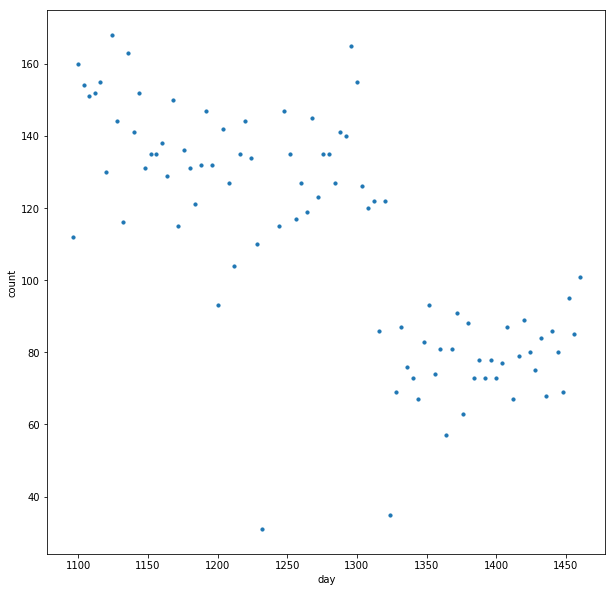

i 8 j 0 2018-07-04 1.0
i 8 j 0 2018-03-18 5.0
i 8 j 1 2018-03-18 5.0
i 8 j 0 2018-12-19 1.0
i 8 j 1 2018-12-19 1.0
i 8 j 2 2018-12-19 1.0
i 8 j 0 2018-03-10 3.0
i 8 j 1 2018-03-10 3.0
i 8 j 2 2018-03-10 3.0
i 8 j 0 2018-02-14 5.0
i 8 j 0 2018-04-27 6.0
i 8 j 0 2018-07-08 1.0
i 8 j 1 2018-07-08 1.0
i 8 j 2 2018-07-08 1.0
i 8 j 0 2018-07-20 3.0
i 8 j 0 2018-07-24 3.0
i 8 j 0 2018-02-10 2.0
i 8 j 0 2018-12-11 4.0
i 8 j 0 2018-08-13 4.0
i 8 j 0 2018-09-22 1.0
i 8 j 1 2018-09-22 1.0
i 8 j 0 2018-06-02 2.0
i 8 j 0 2018-03-02 5.0
i 8 j 1 2018-03-02 5.0
i 8 j 0 2018-08-21 2.0
i 8 j 0 2018-09-10 2.0
i 8 j 1 2018-09-10 2.0
i 8 j 0 2018-06-22 5.0
i 8 j 0 2018-12-03 2.0
i 8 j 0 2018-06-14 2.0
i 8 j 0 2018-11-05 1.0
i 8 j 0 2018-05-13 7.0
i 8 j 0 2018-07-28 3.0
i 8 j 1 2018-07-28 3.0
i 8 j 0 2018-02-06 6.0
i 8 j 0 2018-03-22 2.0
i 8 j 1 2018-03-22 2.0
i 8 j 2 2018-03-22 2.0
i 8 j 0 2018-11-09 1.0
i 8 j 0 2018-11-13 1.0
i 8 j 1 2018-11-13 1.0
i 8 j 0 2018-12-15 2.0
i 8 j 0 2018-10-16 1.0
i 8 j 0 201

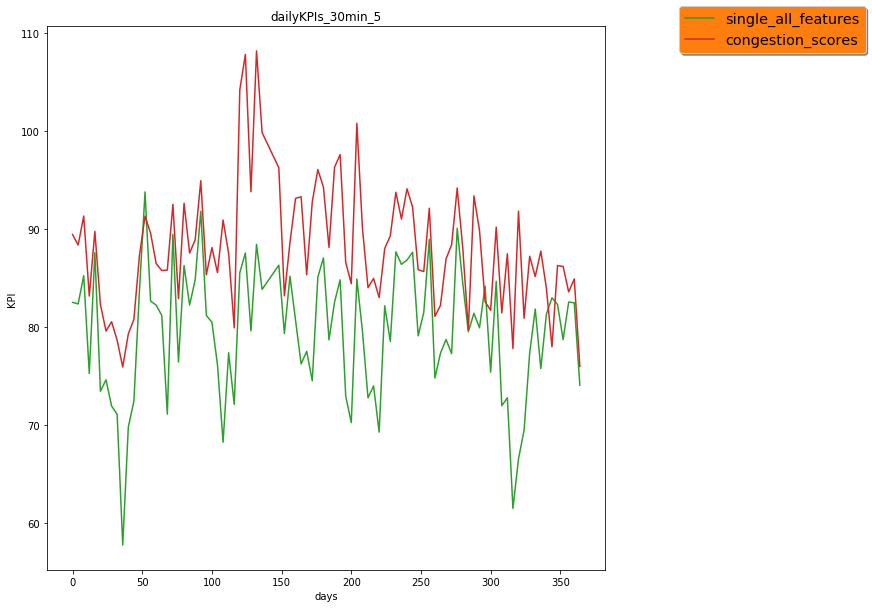

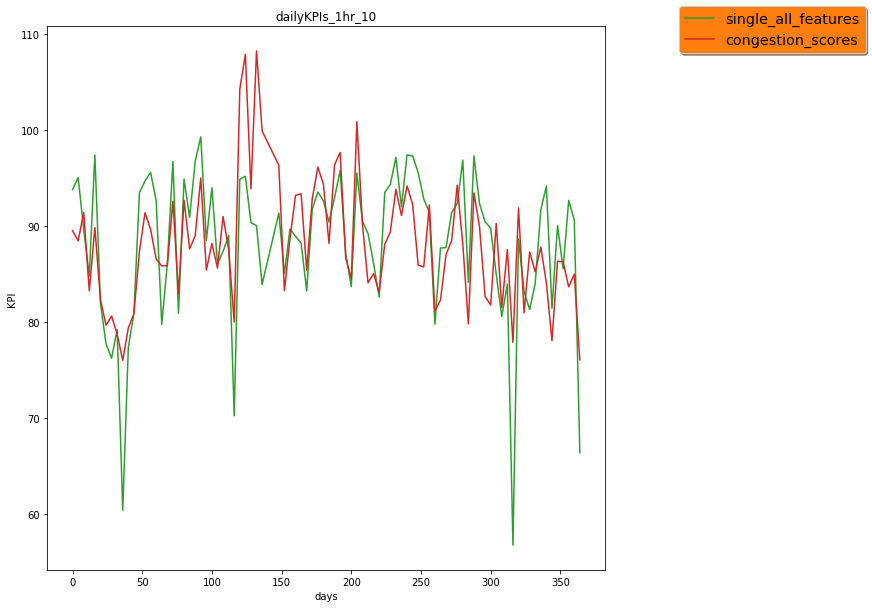

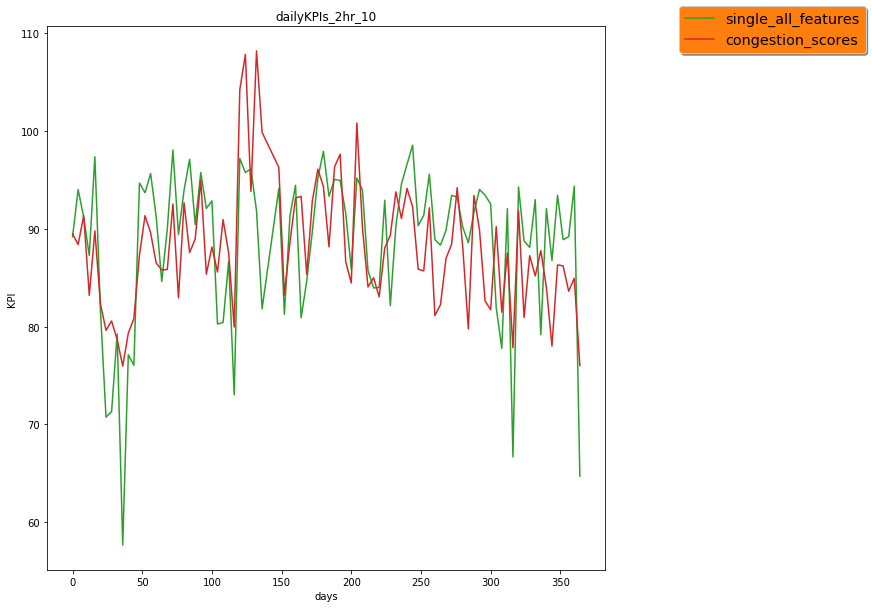


valida time-to-landing (vertical) by accuracy (horizontal)
+----+------+------+-----+------+------+------+------+-----+------+------+------+------+-----+------+------+------+
|    | <= 5 | AVG  | STD | MIN  | MAX  | <=10 | AVG  | STD | MIN  | MAX  | <=15 | AVG  | STD | MIN  | MAX  | SIZE |
+----+------+------+-----+------+------+------+------+-----+------+------+------+------+-----+------+------+------+
|30m | 79.5%| 79.6%| 6.7%| 57.8%| 93.8%| 96.1%| 96.1%| 2.9%| 83.8%| 99.8%| 99.1%| 99.1%| 0.8%| 96.2%|100.0%| 61445|
|1hr | 65.5%| 65.2%| 9.3%| 39.7%| 87.0%| 88.3%| 88.2%| 7.8%| 56.7%| 99.2%| 95.2%| 95.3%| 5.2%| 71.6%|100.0%|  9967|
|90m | 64.7%| 64.4%| 9.9%| 35.3%| 88.1%| 88.8%| 88.6%| 7.9%| 57.6%| 98.6%| 95.4%| 95.3%| 5.5%| 65.9%|100.0%|  7685|
|2hr | 59.3%| 59.2%| 9.7%| 33.8%| 83.0%| 83.2%| 83.4%| 8.8%| 49.3%| 96.7%| 92.0%| 92.1%| 6.5%| 60.6%|100.0%|  5276|
|3hr | 54.8%| 53.9%|11.3%| 20.0%| 80.9%| 84.7%| 84.3%| 8.2%| 64.2%|100.0%| 95.3%| 95.1%| 5.1%| 73.6%|100.0%|  4597|
|4hr | 44.6%

In [126]:
test(validation_data_set, preds_df, "valida")


Median Absolute Percent Error (MdAPE) =  0.05867164571616925

r-squared =  0.9956753238791628

r-squared-adjusted = 0.99566316145544 where number of parameters:1296 and number of observations:461768


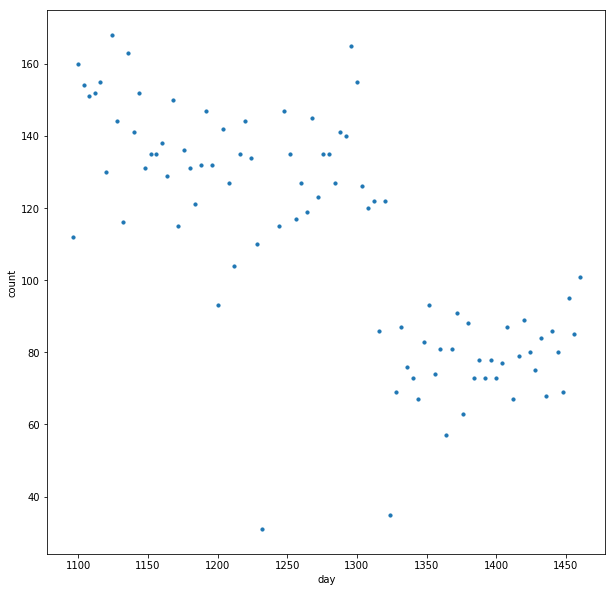

i 8 j 0 2018-07-04 1.0
i 8 j 0 2018-03-18 5.0
i 8 j 1 2018-03-18 5.0
i 8 j 0 2018-12-19 1.0
i 8 j 1 2018-12-19 1.0
i 8 j 2 2018-12-19 1.0
i 8 j 0 2018-03-10 3.0
i 8 j 1 2018-03-10 3.0
i 8 j 2 2018-03-10 3.0
i 8 j 0 2018-02-14 5.0
i 8 j 0 2018-04-27 6.0
i 8 j 0 2018-07-08 1.0
i 8 j 1 2018-07-08 1.0
i 8 j 2 2018-07-08 1.0
i 8 j 0 2018-07-20 3.0
i 8 j 0 2018-07-24 3.0
i 8 j 0 2018-02-10 2.0
i 8 j 0 2018-12-11 4.0
i 8 j 0 2018-08-13 4.0
i 8 j 0 2018-09-22 1.0
i 8 j 1 2018-09-22 1.0
i 8 j 0 2018-06-02 2.0
i 8 j 0 2018-03-02 5.0
i 8 j 1 2018-03-02 5.0
i 8 j 0 2018-08-21 2.0
i 8 j 0 2018-09-10 2.0
i 8 j 1 2018-09-10 2.0
i 8 j 0 2018-06-22 5.0
i 8 j 0 2018-12-03 2.0
i 8 j 0 2018-06-14 2.0
i 8 j 0 2018-11-05 1.0
i 8 j 0 2018-05-13 7.0
i 8 j 0 2018-07-28 3.0
i 8 j 1 2018-07-28 3.0
i 8 j 0 2018-02-06 6.0
i 8 j 0 2018-03-22 2.0
i 8 j 1 2018-03-22 2.0
i 8 j 2 2018-03-22 2.0
i 8 j 0 2018-11-09 1.0
i 8 j 0 2018-11-13 1.0
i 8 j 1 2018-11-13 1.0
i 8 j 0 2018-12-15 2.0
i 8 j 0 2018-10-16 1.0
i 8 j 0 201

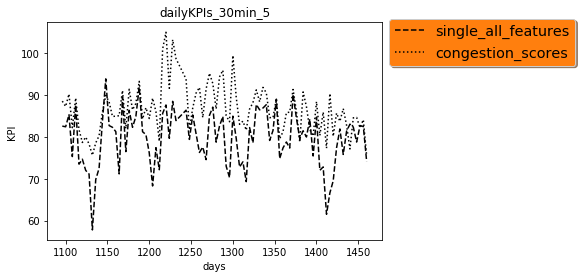

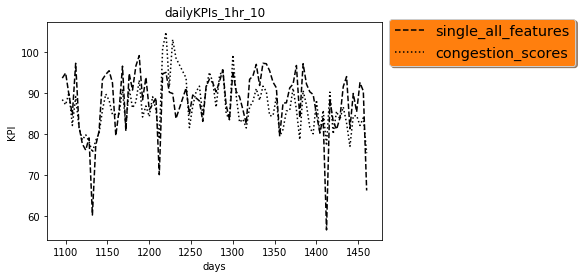

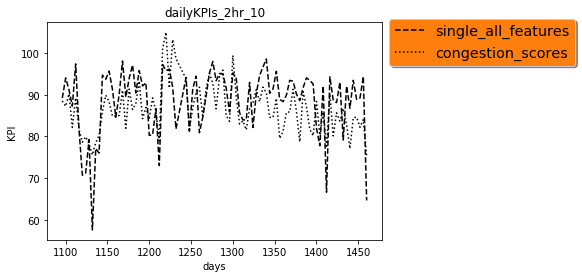


valida time-to-landing (vertical) by accuracy (horizontal)
+----+------+------+-----+------+------+------+------+-----+------+------+------+------+-----+------+------+------+
|    | <= 5 | AVG  | STD | MIN  | MAX  | <=10 | AVG  | STD | MIN  | MAX  | <=15 | AVG  | STD | MIN  | MAX  | SIZE |
+----+------+------+-----+------+------+------+------+-----+------+------+------+------+-----+------+------+------+
|30m | 79.5%| 79.6%| 6.7%| 57.8%| 93.8%| 96.1%| 96.1%| 2.9%| 83.8%| 99.8%| 99.1%| 99.1%| 0.8%| 96.2%|100.0%| 61445|
|1hr | 65.5%| 65.2%| 9.3%| 39.7%| 87.0%| 88.3%| 88.2%| 7.8%| 56.7%| 99.2%| 95.2%| 95.3%| 5.2%| 71.6%|100.0%|  9967|
|90m | 64.7%| 64.4%| 9.9%| 35.3%| 88.1%| 88.8%| 88.6%| 7.9%| 57.6%| 98.6%| 95.4%| 95.3%| 5.5%| 65.9%|100.0%|  7685|
|2hr | 59.3%| 59.2%| 9.7%| 33.8%| 83.0%| 83.2%| 83.4%| 8.8%| 49.3%| 96.7%| 92.0%| 92.1%| 6.5%| 60.6%|100.0%|  5276|
|3hr | 54.8%| 53.9%|11.3%| 20.0%| 80.9%| 84.7%| 84.3%| 8.2%| 64.2%|100.0%| 95.3%| 95.1%| 5.1%| 73.6%|100.0%|  4597|
|4hr | 44.6%

In [71]:
test(validation_data_set, preds_df, "valida")

Validation accuracies for scheduled flights

Median Absolute Percent Error (MdAPE) =  0.036408874186864504

r-squared =  0.9780425651250086

r-squared-adjusted = 0.976243117070135 where number of parameters:1296 and number of observations:17098


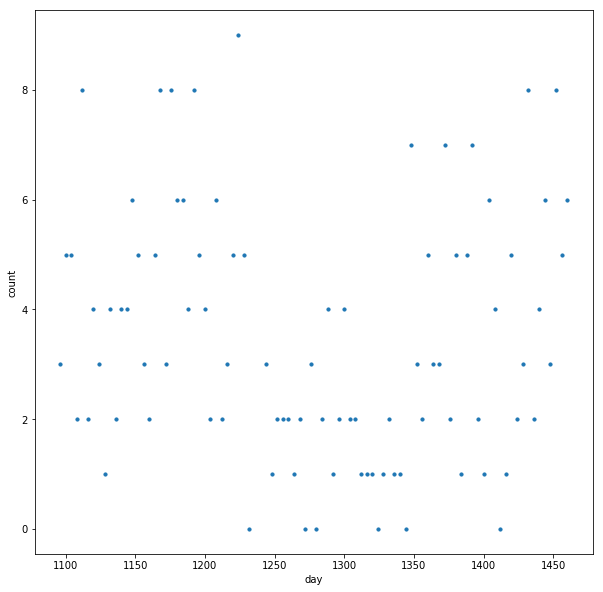

i 3 j 0 2018-03-18 2.0
i 3 j 1 2018-03-18 2.0
i 7 j 0 2018-03-18 1.0
i 8 j 0 2018-03-18 2.0
i 8 j 1 2018-03-18 2.0
i 4 j 0 2018-08-29 2.0
i 4 j 1 2018-08-29 2.0
i 4 j 2 2018-08-29 2.0
i 7 j 0 2018-08-29 4.0
i 7 j 1 2018-08-29 4.0
i 7 j 0 2018-05-09 1.0
i 3 j 0 2018-12-27 1.0
i 3 j 1 2018-12-27 1.0
i 3 j 2 2018-12-27 1.0
i 4 j 0 2018-12-27 2.0
i 4 j 1 2018-12-27 2.0
i 6 j 0 2018-12-27 3.0
i 7 j 0 2018-12-27 4.0
i 7 j 1 2018-12-27 4.0
i 3 j 0 2018-09-30 1.0
i 3 j 1 2018-09-30 1.0
i 5 j 0 2018-09-30 2.0
i 5 j 1 2018-09-30 2.0
i 6 j 0 2018-09-30 1.0
i 6 j 1 2018-09-30 1.0
i 6 j 2 2018-09-30 1.0
i 1 j 0 2018-07-16 1.0
i 6 j 0 2018-07-16 5.0
i 3 j 0 2018-01-09 5.0
i 7 j 0 2018-01-09 1.0
i 7 j 1 2018-01-09 1.0
i 7 j 2 2018-01-09 1.0
i 1 j 0 2018-11-01 1.0
i 1 j 1 2018-11-01 1.0
i 2 j 0 2018-02-26 2.0
i 2 j 1 2018-02-26 2.0
i 3 j 0 2018-02-26 5.0
i 4 j 0 2018-04-07 3.0
i 4 j 1 2018-04-07 3.0
i 4 j 2 2018-04-07 3.0
i 7 j 0 2018-04-07 5.0
i 7 j 1 2018-04-07 5.0
i 7 j 2 2018-04-07 5.0
i 3 j 0 201

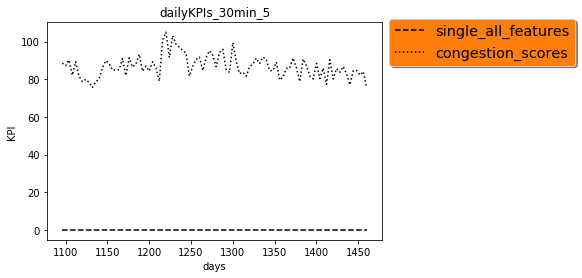

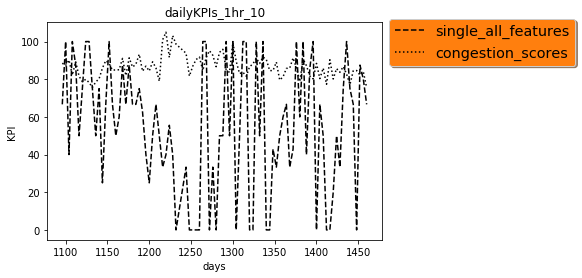

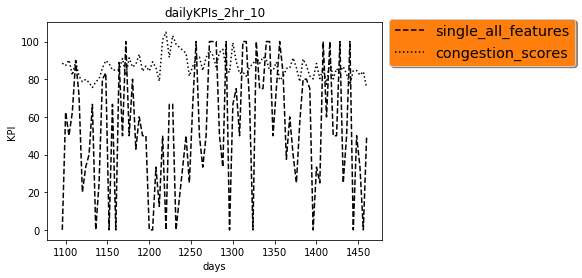


sched  time-to-landing (vertical) by accuracy (horizontal)
+----+------+------+-----+------+------+------+------+-----+------+------+------+------+-----+------+------+------+
|    | <= 5 | AVG  | STD | MIN  | MAX  | <=10 | AVG  | STD | MIN  | MAX  | <=15 | AVG  | STD | MIN  | MAX  | SIZE |
+----+------+------+-----+------+------+------+------+-----+------+------+------+------+-----+------+------+------+
|30m |  0.0%|  0.0%| 0.0%|  0.0%|  0.0%|  0.0%|  0.0%| 0.0%|  0.0%|  0.0%| 33.3%|  1.1%|10.5%|  0.0%|100.0%|     3|
|1hr | 41.4%| 33.8%|31.6%|  0.0%|100.0%| 61.2%| 54.5%|30.4%|  0.0%|100.0%| 78.6%| 72.3%|24.9%|  0.0%|100.0%|   309|
|90m | 29.4%| 26.7%|25.0%|  0.0%|100.0%| 57.9%| 54.5%|30.8%|  0.0%|100.0%| 81.7%| 77.2%|23.2%|  0.0%|100.0%|   361|
|2hr | 19.2%| 19.7%|24.6%|  0.0%|100.0%| 38.4%| 39.2%|30.4%|  0.0%|100.0%| 66.3%| 66.3%|29.3%|  0.0%|100.0%|   344|
|3hr | 24.4%| 13.6%|30.2%|  0.0%|100.0%| 44.9%| 24.5%|37.5%|  0.0%|100.0%| 51.3%| 27.3%|37.7%|  0.0%|100.0%|    78|
|4hr | 42.9%

In [72]:
print("Validation accuracies for scheduled flights")
columns_size =  validation_data_set.shape[1]
sched_set = validation_data_set[validation_data_set[columns_size-1] == 0]
sched_set = sched_set.reset_index(drop=True)
sched_pred = preds_df[validation_data_set[columns_size-1] == 0]
sched_pred = sched_pred.reset_index(drop=True)
test(sched_set, sched_pred, "sched ")

Validation accuracies for departed flights

Median Absolute Percent Error (MdAPE) =  0.06005633109360519

r-squared =  0.9966444773798091

r-squared-adjusted = 0.996634662519535 where number of parameters:1296 and number of observations:444033


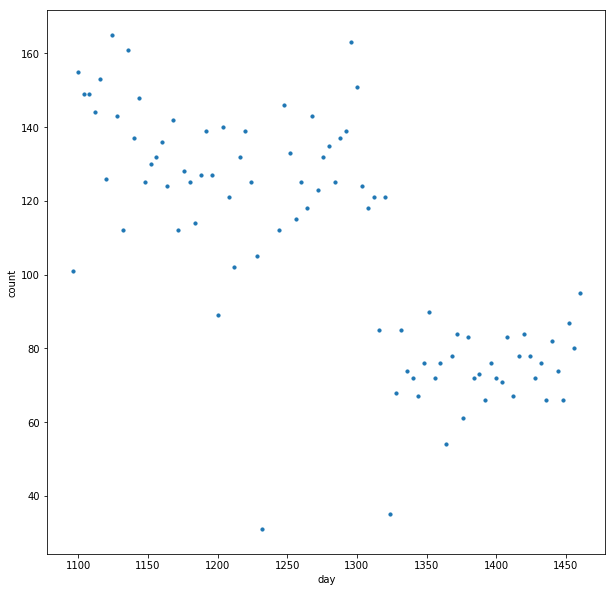

i 8 j 0 2018-02-10 1.0
i 8 j 0 2018-12-11 1.0
i 8 j 1 2018-12-11 1.0
i 8 j 0 2018-12-19 1.0
i 8 j 1 2018-12-19 1.0
i 8 j 2 2018-12-19 1.0
i 8 j 0 2018-08-13 2.0
i 8 j 0 2018-09-22 1.0
i 8 j 1 2018-09-22 1.0
i 8 j 0 2018-06-02 2.0
i 8 j 0 2018-03-02 3.0
i 8 j 1 2018-03-02 3.0
i 8 j 0 2018-08-21 2.0
i 8 j 0 2018-09-10 2.0
i 8 j 1 2018-09-10 2.0
i 8 j 0 2018-04-27 3.0
i 8 j 1 2018-04-27 3.0
i 8 j 0 2018-01-17 3.0
i 8 j 1 2018-01-17 3.0
i 8 j 0 2018-07-04 1.0
i 8 j 0 2018-02-14 2.0
i 8 j 0 2018-06-22 2.0
i 8 j 0 2018-03-18 3.0
i 8 j 1 2018-03-18 3.0
i 8 j 2 2018-03-18 3.0
i 8 j 0 2018-06-14 2.0
i 8 j 0 2018-11-05 1.0
i 8 j 0 2018-05-13 1.0
i 8 j 0 2018-07-24 3.0
i 8 j 0 2018-07-28 3.0
i 8 j 1 2018-07-28 3.0
i 8 j 0 2018-04-19 6.0
i 8 j 1 2018-04-19 6.0
i 8 j 0 2018-02-06 5.0
i 8 j 0 2018-03-22 2.0
i 8 j 1 2018-03-22 2.0
i 8 j 2 2018-03-22 2.0
i 8 j 0 2018-03-14 4.0
i 8 j 0 2018-11-09 1.0
i 8 j 0 2018-07-20 3.0
i 8 j 0 2018-11-13 1.0
i 8 j 1 2018-11-13 1.0
i 8 j 0 2018-07-08 1.0
i 8 j 1 201

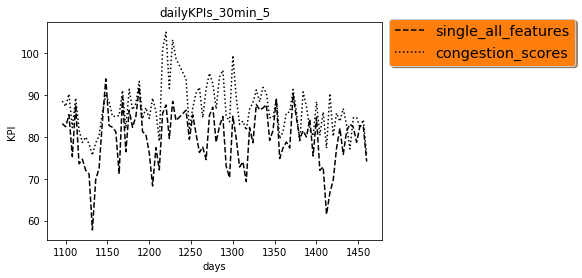

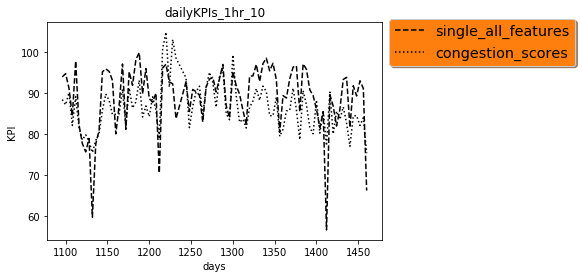

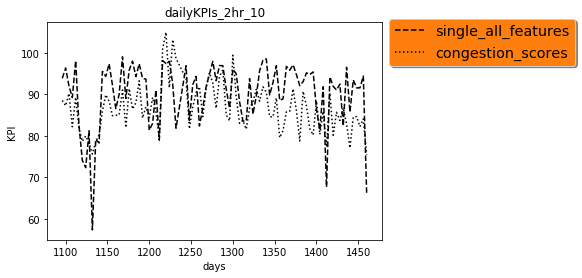


depart time-to-landing (vertical) by accuracy (horizontal)
+----+------+------+-----+------+------+------+------+-----+------+------+------+------+-----+------+------+------+
|    | <= 5 | AVG  | STD | MIN  | MAX  | <=10 | AVG  | STD | MIN  | MAX  | <=15 | AVG  | STD | MIN  | MAX  | SIZE |
+----+------+------+-----+------+------+------+------+-----+------+------+------+------+-----+------+------+------+
|30m | 79.5%| 79.6%| 6.7%| 57.8%| 93.8%| 96.1%| 96.1%| 2.9%| 83.8%| 99.8%| 99.1%| 99.1%| 0.8%| 96.2%|100.0%| 61359|
|1hr | 66.2%| 66.1%| 9.6%| 39.3%| 88.2%| 89.1%| 89.1%| 8.0%| 56.7%|100.0%| 95.8%| 95.9%| 5.5%| 71.4%|100.0%|  9647|
|90m | 66.5%| 66.2%|10.0%| 35.4%| 91.2%| 90.3%| 90.2%| 7.8%| 57.3%| 99.0%| 96.0%| 96.0%| 5.5%| 65.9%|100.0%|  7316|
|2hr | 62.1%| 62.1%|10.5%| 32.6%| 86.2%| 86.4%| 86.7%| 9.5%| 48.6%|100.0%| 93.8%| 94.0%| 6.8%| 60.0%|100.0%|  4927|
|3hr | 55.3%| 54.4%|11.4%| 20.0%| 81.8%| 85.4%| 85.1%| 8.1%| 64.7%|100.0%| 96.1%| 96.0%| 4.6%| 76.5%|100.0%|  4513|
|4hr | 44.8%

In [73]:
print("Validation accuracies for departed flights")
columns_size =  validation_data_set.shape[1]
departed_set = validation_data_set[validation_data_set[columns_size-1] == 1]
departed_set = departed_set.reset_index(drop=True)
departed_pred = preds_df[validation_data_set[columns_size-1] == 1]
departed_pred = departed_pred.reset_index(drop=True)
test(departed_set, departed_pred, "depart")

### PLOT

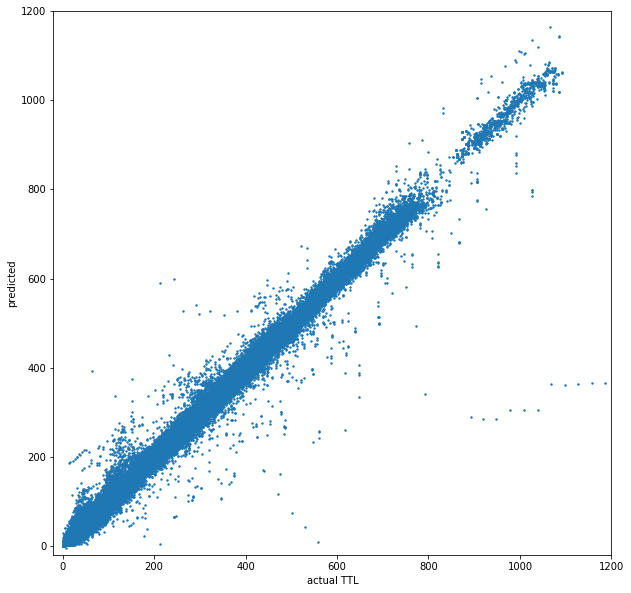

In [74]:
import matplotlib.pyplot as plt

labels = validation_data_set.iloc[:,TARGET_INDEX] 

labels = [float(i) for i in labels]
labels = np.array(labels)     
    
plt.figure(figsize=(10,10))
plt.xlabel('actual TTL')
plt.ylabel('predicted')
plt.scatter(labels/60, np.array(preds)/60, s=2)
plt.xlim(-20,1200);
plt.ylim(-20,1200);
plt.show()

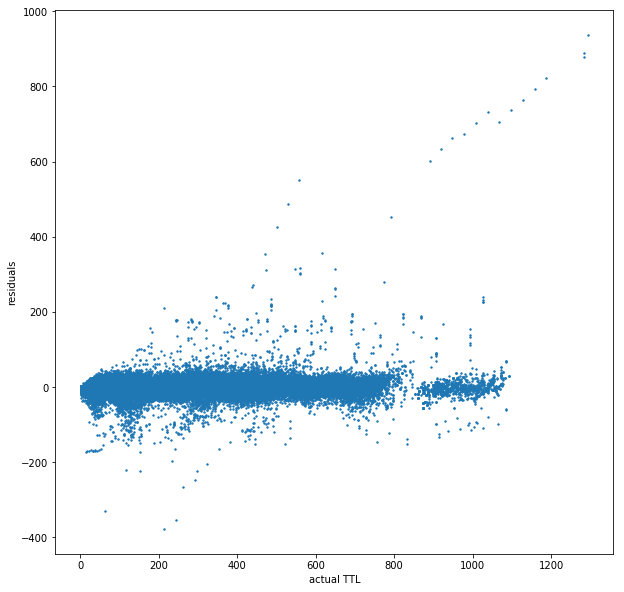

In [75]:
residuals = np.array(labels) -  np.array(preds)
 
plt.figure(figsize=(10,10))
plt.xlabel('actual TTL')
plt.ylabel('residuals')
plt.scatter(labels/60, residuals/60, s=2)
plt.show()

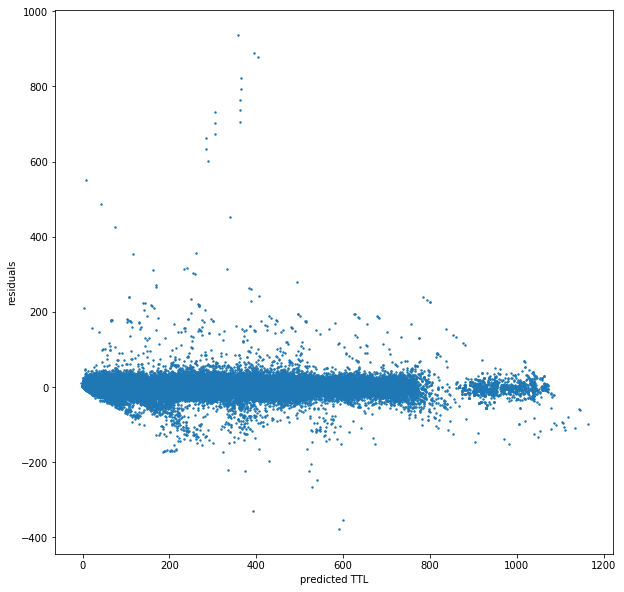

In [76]:

plt.figure(figsize=(10,10))
plt.xlabel('predicted TTL')
plt.ylabel('residuals')
plt.scatter(np.array(preds)/60, residuals/60, s=2)
plt.show()


# If you can predict the residuals based on the predicted value, if you see non-random patterns in your residuals, it means that your predictors are missing something.
# Possibilities include:
#   A missing variable
#   A missing higher-order term of a variable in the model to explain the curvature
#   A missing interaction between terms already in the model


### Save Endpoint
If you are happy with validation accuracies, then save endpoint name to modelversion table in the database.

Put endpointname to endpoint column.

Put version to version column. Here the version is the version you renamed after creating Sagemaker model in training VM.


In [77]:
endpoint_name

'WSSS-TTL-XGBoost-2019-11-13-11-06-56-model-XGBoostEndpoint'

In [78]:
import s3fs
import pickle
import tarfile
import xgboost

model_path = 's3://sagemaker-models-data/'+airport+'/TTL/model/xgboost-regression/'+job_name+'/output/model.tar.gz'

fs = s3fs.S3FileSystem()

with fs.open(model_path, 'rb') as f:
    with tarfile.open(fileobj=f, mode='r') as tar_f:
        with tar_f.extractfile('xgboost-model') as extracted_f:
            xgbooster = pickle.load(extracted_f)

scores = xgbooster.get_fscore()

ModuleNotFoundError: No module named 'xgboost'

In [ ]:
from xgboost import plot_importance

xgbooster.feature_names = np.array(training_data_set.iloc[0,TARGET_INDEX+1:]).tolist()

fig, ax = plt.subplots(1,1,figsize=(10,10))
plot_importance(xgbooster, max_num_features=20, ax=ax)
plt.show()

### Delete Endpoint
Once you do not want to keep this endpoint, you can use the following to delete it. 
Also delete model tar file from s3.

client.delete_endpoint(EndpointName=endpoint_name)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Make some fake data.
days = [1,2,3,4,5,6,7,8,9,10]

all_5_30min        =[74,73,70,83,70,79,64,78,81,72]
all_5_1hr          =[86,85,82,90,82,92,77,89,93,88]
all_5_2hr          =[76,71,72,74,73,73,62,73,73,73]

all_features_30min =[66,56,59,57,57,58,55,60,60,59]
all_features_1hr   =[77,71,72,77,74,80,66,77,75,78]
all_features_2hr   =[64,56,56,59,57,61,52,60,58,59]
  
no_waypoints_30min =[62,55,60,63,59,62,62,56,59,56]
no_waypoints_1hr   =[74,74,73,80,74,80,65,74,77,77]
no_waypoints_2hr   =[55,50,51,50,48,51,42,42,40,45]


# Create plots with pre-defined labels.
fig, ax = plt.subplots()

ax.plot(days, all_5_30min, 'k--', label='all5')
ax.plot(days, all_features_30min, 'k:', label='single_all_features')
ax.plot(days, no_waypoints_30min, 'k', label='single_no_waypoints')
ax.set_title('30min_5')
ax.set_xlabel('days')
ax.set_ylabel('KPI')

legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large', bbox_to_anchor=(1.3, 1.05))

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C1')

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Make some fake data.
days = [1,2,3,4,5,6,7,8,9,10]

all_5_30min        =[74,73,70,83,70,79,64,78,81,72]
all_5_1hr          =[86,85,82,90,82,92,77,89,93,88]
all_5_2hr          =[76,71,72,74,73,73,62,73,73,73]

all_features_30min =[66,56,59,57,57,58,55,60,60,59]
all_features_1hr   =[77,71,72,77,74,80,66,77,75,78]
all_features_2hr   =[64,56,56,59,57,61,52,60,58,59]
  
no_waypoints_30min =[62,55,60,63,59,62,62,56,59,56]
no_waypoints_1hr   =[74,74,73,80,74,80,65,74,77,77]
no_waypoints_2hr   =[55,50,51,50,48,51,42,42,40,45]


# Create plots with pre-defined labels.
fig, ax = plt.subplots()

ax.plot(days, all_5_1hr, 'k--', label='all5')
ax.plot(days, all_features_1hr, 'k:', label='single_all_features')
ax.plot(days, no_waypoints_1hr, 'k', label='single_no_waypoints')
ax.set_title('1hr_10')
ax.set_xlabel('days')
ax.set_ylabel('KPI')

legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large', bbox_to_anchor=(1.3, 1.05))

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C1')

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Make some fake data.
days = [1,2,3,4,5,6,7,8,9,10]

all_5_30min        =[74,73,70,83,70,79,64,78,81,72]
all_5_1hr          =[86,85,82,90,82,92,77,89,93,88]
all_5_2hr          =[76,71,72,74,73,73,62,73,73,73]

all_features_30min =[66,56,59,57,57,58,55,60,60,59]
all_features_1hr   =[77,71,72,77,74,80,66,77,75,78]
all_features_2hr   =[64,56,56,59,57,61,52,60,58,59]
  
no_waypoints_30min =[62,55,60,63,59,62,62,56,59,56]
no_waypoints_1hr   =[74,74,73,80,74,80,65,74,77,77]
no_waypoints_2hr   =[55,50,51,50,48,51,42,42,40,45]


# Create plots with pre-defined labels.
fig, ax = plt.subplots()

ax.plot(days, all_5_2hr, 'k--', label='all5')
ax.plot(days, all_features_2hr, 'k:', label='single_all_features')
ax.plot(days, no_waypoints_2hr, 'k', label='single_no_waypoints')
ax.set_title('2hr_10')
ax.set_xlabel('days')
ax.set_ylabel('KPI')

legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large', bbox_to_anchor=(1.3, 1.05))

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C1')

plt.show()

In [ ]:

all_5_1_2hr_10          =[92,86,86,94,84,91,73,93,93,91]
all_5_2_4hr_15          =[95,90,92,95,93,93,82,95,95,92]

all_features_1_2hr_10   =[84,77,77,81,74,81,69,81,78,81]
all_features_2_4hr_15   =[90,86,85,89,86,89,80,91,89,92]

no_waypoints_1_2hr_10   =[82,78,76,83,74,80,64,72,73,75]
no_waypoints_2_4hr_15   =[89,85,82,86,84,85,76,77,78,82]



# Create plots with pre-defined labels.
fig, ax = plt.subplots()

ax.plot(days, all_5_1_2hr_10, 'k--', label='all5')
ax.plot(days, all_features_1_2hr_10, 'k:', label='single_all_features')
ax.plot(days, no_waypoints_1_2hr_10, 'k', label='single_no_waypoints')
ax.set_title('1_2hr_10')
ax.set_xlabel('days')
ax.set_ylabel('KPI')

legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large', bbox_to_anchor=(1.3, 1.05))

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C1')

plt.show()

In [ ]:
all_5_1_2hr_10          =[92,86,86,94,84,91,73,93,93,91]
all_5_2_4hr_15          =[95,90,92,95,93,93,82,95,95,92]

all_features_1_2hr_10   =[84,77,77,81,74,81,69,81,78,81]
all_features_2_4hr_15   =[90,86,85,89,86,89,80,91,89,92]

no_waypoints_1_2hr_10   =[82,78,76,83,74,80,64,72,73,75]
no_waypoints_2_4hr_15   =[89,85,82,86,84,85,76,77,78,82]



# Create plots with pre-defined labels.
fig, ax = plt.subplots()

ax.plot(days, all_5_2_4hr_15, 'k--', label='all5')
ax.plot(days, all_features_2_4hr_15, 'k:', label='single_all_features')
ax.plot(days, no_waypoints_2_4hr_15, 'k', label='single_no_waypoints')
ax.set_title('2_4hr_15')
ax.set_xlabel('days')
ax.set_ylabel('KPI')

legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large', bbox_to_anchor=(1.3, 1.05))

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C1')

plt.show()